## Model Perfromance Metrics

Note: Notebook has been heavily adapted from Christopher V. Cosgriff, MD, MPH work on sequential severity prediction for critically ill patients (Source: https://github.com/cosgriffc/seq-severityscore)

<hr />

## Environment

In [1]:
import pandas as pd
import numpy as np
import pickle

from model_analysis import APACHEWrapper, SVCWrapper
from model_analysis import gen_auc_plot
from model_analysis import opr_table, sens_spec_table

# Load seaborn to set plot styles
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Load Models and Data


In [2]:
train_X = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid')
train_y = pd.read_csv('../extraction/data/train_y.csv').values.ravel()
cols = train_X.columns

test_apache = pd.read_csv('../extraction/data/test_apache.csv')
missing_apache_prob = (test_apache['apache_prediction'].isna())
test_apache = test_apache[~missing_apache_prob].values.ravel()
apache_model = APACHEWrapper(test_apache)

test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid')
test_y = pd.read_csv('../extraction/data/test_y.csv')
test_X = test_X[list(~missing_apache_prob)]
test_y = test_y[list(~missing_apache_prob)].values.ravel()

# ML models
logit_full = pickle.load(open('./logit_full', 'rb'))
xgb_full = pickle.load(open('./xgb_full', 'rb'))
rf_full = pickle.load(open('./rf_full', 'rb'))

## Plot Receiver Operator Characteristic Curves

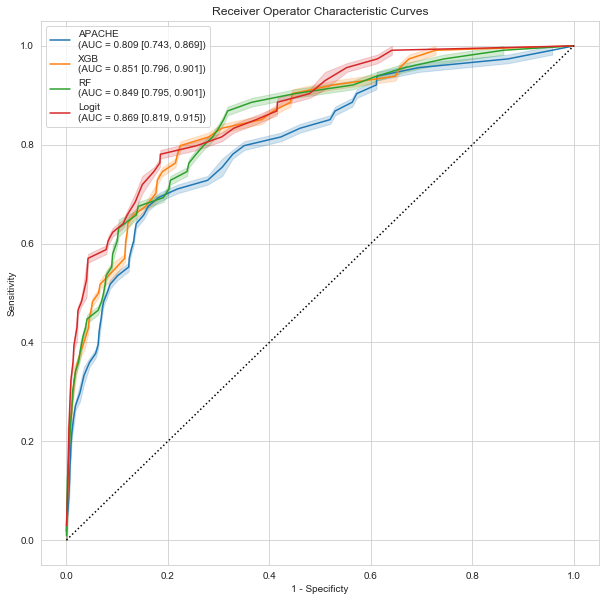

In [3]:
gen_auc_plot(models=[apache_model,xgb_full, rf_full, logit_full],
             names=['APACHE', 'XGB','RF','Logit'], 
             title='Receiver Operator Characteristic Curves', X=test_X, y=test_y, ci_level=0.95,
             save_name='auroc_all_models_test')

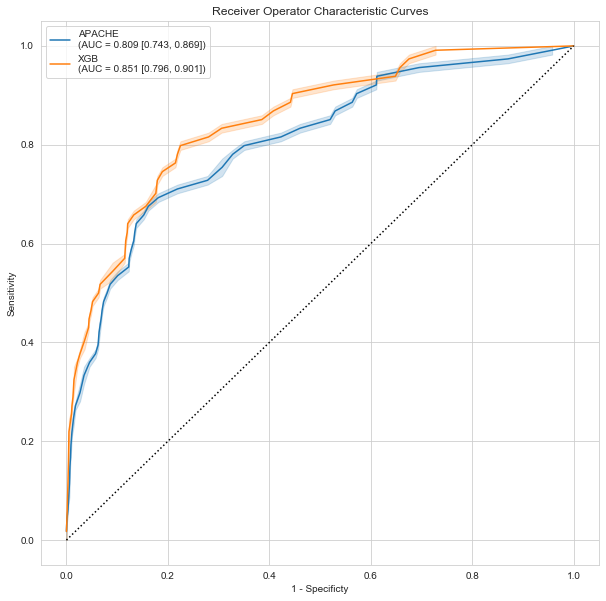

In [4]:
gen_auc_plot(models=[apache_model,xgb_full],
             names=['APACHE', 'XGB'], 
             title='Receiver Operator Characteristic Curves', X=test_X, y=test_y, ci_level=0.95,
             save_name='auroc_test')

## Observed-to-Predicted Mortality Ratios 

In [5]:
opr = opr_table(models=[apache_model,logit_full, rf_full, xgb_full],
                names=['APACHE','Logit','RF', 'XGB'],
                X=test_X, y=test_y)
opr.to_csv('./opr-table.csv')
opr

,OPR,2.5%,97.5%
APACHE,0.657328,0.505834,0.813714
Logit,0.961687,0.758894,1.177324
RF,0.933491,0.727482,1.143670
XGB,0.996815,0.783988,1.225757


## Threshold for High Sensitivity 

In [6]:
# 95% Sensitivity
spec_at_high_sens = sens_spec_table(models=[apache_model,logit_full, rf_full, xgb_full],
                names=['APACHE','Logit','RF', 'XGB'],
                X=test_X, y=test_y, sens=0.945)

spec_at_high_sens

,Sens,Spec,2.5%,97.5%
APACHE,0.947368,0.387129,0.041056,0.473214
Logit,0.947368,0.488119,0.357002,0.609467
RF,0.947368,0.385149,0.142000,0.684262
XGB,0.947368,0.351485,0.281899,0.589232


In [7]:
# 100% Sensitivity
spec_at_high_sens = sens_spec_table(models=[apache_model,logit_full, rf_full, xgb_full],
                names=['APACHE','Logit','RF', 'XGB'],
                X=test_X, y=test_y, sens=0.995)

spec_at_high_sens

,Sens,Spec,2.5%,97.5%
APACHE,1.0,0.041584,0.029058,0.384008
Logit,1.0,0.357426,0.331668,0.493519
RF,1.0,0.133663,0.114286,0.381281
XGB,1.0,0.272277,0.245562,0.362832
